# Experiment: RPCA vs. Matrix Completion Techniques
## Steam Games Dataset
### Neil Menghani and Jeffrey Tumminia

#### Required Packages:

- cvxpy
- cvxopt
- matrix_completion
- rpca.py file provided; Source: https://github.com/dganguli/robust-pca
- fancyimpute
- pylab
- seaborn

In [48]:
import numpy as np
import pandas as pd
import matrix_completion as mc
from rpca import R_pca
from fancyimpute import KNN
from pylab import plt
import seaborn as sns
sns.set_theme()

### Load and Clean Steam Dataset

In [5]:
steam_df = pd.read_csv("steam-200k.csv", header=None, names=['user_id', 'game', 'behavior', 'hours', '0']).drop('0', axis=1)

In [6]:
# Restrict to popular games and active users
top_games_df = steam_df.loc[steam_df['behavior'] == 'play']
top_games_df = top_games_df.groupby('game').agg({'user_id':'count', 'hours':'sum'}).sort_values('user_id', ascending=False)
top_games_df = top_games_df.loc[top_games_df['user_id'] >= 100]
top_games = list(top_games_df.index)
top_users_df = steam_df.loc[(steam_df['behavior'] == 'play') & (steam_df['game'].isin(top_games))]
top_users_df = top_users_df.groupby('user_id').agg({'game':'count'}).sort_values('game', ascending=False)
top_users_df = top_users_df.loc[top_users_df['game'] >= 25]
top_users = list(top_users_df.index)

In [7]:
steam_df = steam_df.loc[(steam_df['game'].isin(top_games)) & (steam_df['user_id'].isin(top_users))]
purchase_df = steam_df.loc[steam_df['behavior'] == 'purchase']
play_df = steam_df.loc[steam_df['behavior'] == 'play']
print(len(purchase_df), len(play_df))

9969 8009


In [8]:
users = list(steam_df['user_id'].unique())
games = list(steam_df['game'].unique())
users.sort()
games.sort()
print("Unique Users: {}, Unique Games: {}".format(len(users), len(games)))

Unique Users: 223, Unique Games: 133


### Generate Collaborative Filtering Matrices with Varying Corruption

In [50]:
np.random.seed(1600)

# Assign fraction of data to test set
THRESHOLD = 0.1
play_df['dataset'] = np.random.rand(len(play_df))
play_df['dataset'] = play_df['dataset'].apply(lambda x : 'test' if x < THRESHOLD else 'train')

# Take fraction of the data as outlier
thresholds = np.linspace(0, 0.3, 7)
A_list = []
for t in range(len(thresholds)):
    A = np.zeros((len(users), len(games))) # hours played of games by users
    B = np.zeros((len(users), len(games))) # binary matrix specifying known vs. unknown
    test_coords = {} # matrix coordinates : hours_played for test data
    for i in range(len(users)):
        user = users[i]
        # print(i)
        purchased = purchase_df.loc[purchase_df['user_id'] == user]['game'].unique()
        user_play_df = play_df.loc[play_df['user_id'] == user]
        played = user_play_df['game'].unique()
        hours_played = pd.Series(user_play_df.hours.values, index=user_play_df.game).to_dict()
        dataset = pd.Series(user_play_df.dataset.values, index=user_play_df.game).to_dict()
        for j in range(len(games)):
            game = games[j]
            if game in played:
                if dataset[game] == 'train':
                    outlier = ((-1 if np.random.randint(2) else 1) * np.random.uniform(1000, 10000))
                    # print(outlier)
                    A[i, j] = outlier if (np.random.rand() < thresholds[t]) else hours_played[game]
                    B[i, j] = 1
                else:
                    test_coords[(i, j)] = hours_played[game]
    A_list.append(A)

<ipython-input-50-7d2daf804c6d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_df['dataset'] = np.random.rand(len(play_df))
<ipython-input-50-7d2daf804c6d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_df['dataset'] = play_df['dataset'].apply(lambda x : 'test' if x < THRESHOLD else 'train')


### Function to Calculate Root Mean Squared Error

In [46]:
def calc_rmse(coords, A_filled):
    total_error = 0
    for coord in coords:
        i, j = coord[0], coord[1]
        hours_pred = A_filled[i, j]
        hours_true = test_coords[coord]
        total_error += (hours_pred - hours_true)**2
        # print(hours_pred, hours_true)
    RMSE = np.sqrt(total_error / len(coords))
    return RMSE

### Run Matrix Completion Techniques

-------------------------------------------
Percent of Data Corrupted: 0.0%
Matrix Completion RMSE: 302.10178517042016


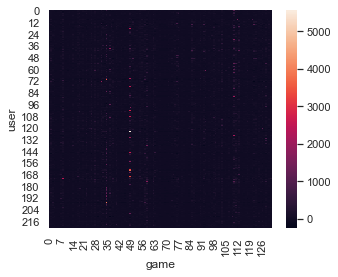

iteration: 1, error: 39.681222091932774
iteration: 100, error: 1.6165670541887385
iteration: 200, error: 1.193692331238148
iteration: 300, error: 0.9521524214616774
iteration: 400, error: 0.5907982393912963
iteration: 500, error: 0.4115142312091405
iteration: 600, error: 0.32720843631513713
iteration: 700, error: 0.1433057540668483
iteration: 800, error: 0.14101398575895543
iteration: 900, error: 0.09207050184374352
iteration: 1000, error: 0.07626738357820781
iteration: 1100, error: 0.06375373196912174
iteration: 1200, error: 0.0529068265248956
iteration: 1300, error: 0.05407201510902689
iteration: 1400, error: 0.05163814266092416
iteration: 1500, error: 0.05982186426547346
iteration: 1600, error: 0.05423951826471337
iteration: 1700, error: 0.06109239876227055
iteration: 1800, error: 0.06580548196361566
iteration: 1900, error: 0.05131102861390799
iteration: 2000, error: 0.04839168771046229
iteration: 2100, error: 0.053512880451486534
iteration: 2200, error: 0.049306316657851866
iterati

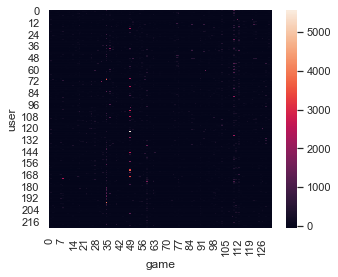

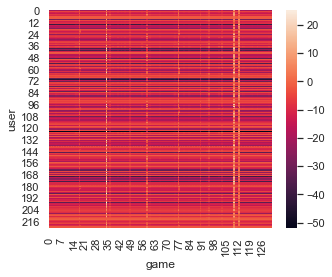

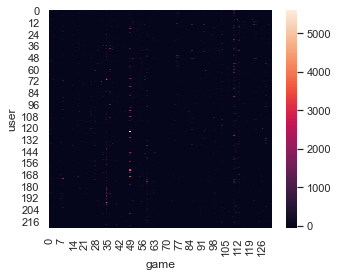

Robust PCA RMSE: 316.98786412504285
Imputing row 1/223 with 77 missing, elapsed time: 0.044
Imputing row 101/223 with 102 missing, elapsed time: 0.154
Imputing row 201/223 with 98 missing, elapsed time: 0.271


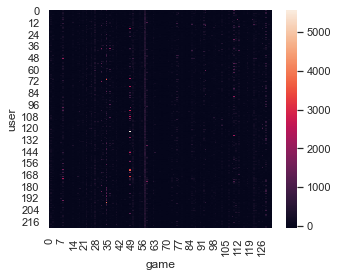

K Nearest Neighbors RMSE: 307.66586318765286
-------------------------------------------
Percent of Data Corrupted: 5.0%
Matrix Completion RMSE: 789.307566167504


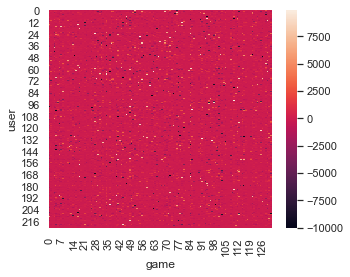

iteration: 1, error: 65.07126722152789
iteration: 100, error: 2.527655956875775
iteration: 200, error: 3.126866576201814
iteration: 300, error: 2.629020050373637
iteration: 400, error: 3.3691751026459795
iteration: 500, error: 2.965136519348959
iteration: 600, error: 3.2710929904291923
iteration: 700, error: 3.4297655927907256
iteration: 800, error: 4.169900938985197
iteration: 900, error: 2.7334273895122965
iteration: 1000, error: 2.2960585392829556
iteration: 1100, error: 1.8918162619686567
iteration: 1200, error: 1.5203524089765719
iteration: 1300, error: 2.2075910527693376
iteration: 1400, error: 1.4737575718553353
iteration: 1500, error: 0.8361298688661721
iteration: 1600, error: 0.5293645009493144
iteration: 1700, error: 0.3894233314152359
iteration: 1800, error: 0.31335066191448274
iteration: 1900, error: 0.12916983250130792
iteration: 2000, error: 0.20396817802757658
iteration: 2100, error: 0.48028816260938756
iteration: 2200, error: 0.07866978644759921
iteration: 2300, error: 

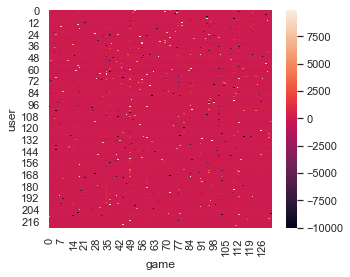

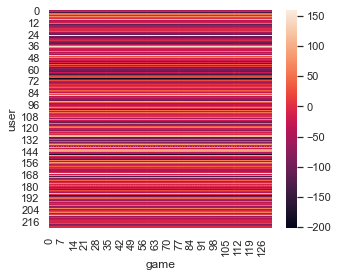

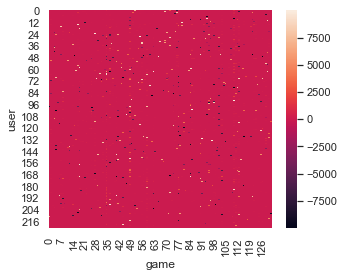

Robust PCA RMSE: 317.878189157079
Imputing row 1/223 with 77 missing, elapsed time: 0.038
Imputing row 101/223 with 102 missing, elapsed time: 0.140
Imputing row 201/223 with 98 missing, elapsed time: 0.251


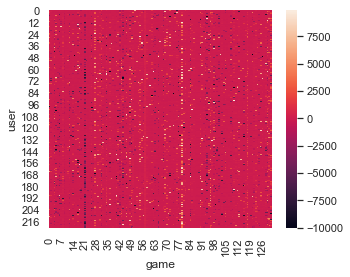

K Nearest Neighbors RMSE: 1086.9696259565744
-------------------------------------------
Percent of Data Corrupted: 10.0%
Matrix Completion RMSE: 957.5169440758999


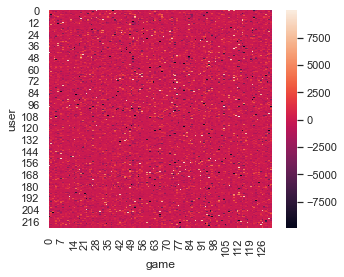

iteration: 1, error: 78.74733977889392
iteration: 100, error: 1.3909488179214926
iteration: 200, error: 1.2830522911107882
iteration: 300, error: 1.9611483028118366
iteration: 400, error: 1.720242859044686
iteration: 500, error: 2.072979771837245
iteration: 600, error: 3.1487511421463195
iteration: 700, error: 2.7158924899073766
iteration: 800, error: 2.502026211407217
iteration: 900, error: 2.462611963259945
iteration: 1000, error: 3.211159417967958
iteration: 1100, error: 3.071025534019108
iteration: 1200, error: 3.788457050771703
iteration: 1300, error: 2.4878047824733787
iteration: 1400, error: 2.158502922092943
iteration: 1500, error: 0.9785652056519916
iteration: 1600, error: 1.6829433033381243
iteration: 1700, error: 0.2824818079551549
iteration: 1800, error: 0.8927729649143964
iteration: 1900, error: 0.4524757367557855
iteration: 2000, error: 0.7748325878962423
iteration: 2100, error: 0.654880851133109
iteration: 2200, error: 0.3046219340371462
iteration: 2300, error: 1.0427091

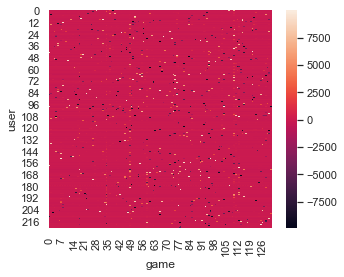

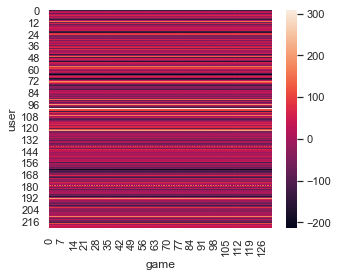

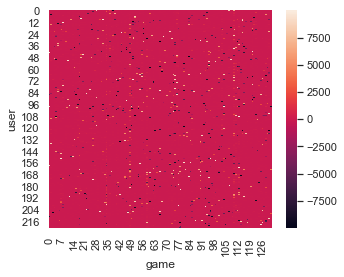

Robust PCA RMSE: 317.89886439047257
Imputing row 1/223 with 77 missing, elapsed time: 0.039
Imputing row 101/223 with 102 missing, elapsed time: 0.144
Imputing row 201/223 with 98 missing, elapsed time: 0.256


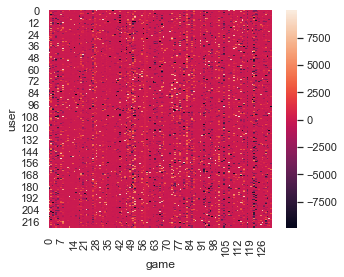

K Nearest Neighbors RMSE: 1383.2033999752582
-------------------------------------------
Percent of Data Corrupted: 15.0%
Matrix Completion RMSE: 1109.3097778607832


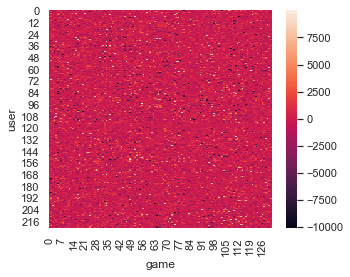

iteration: 1, error: 127.52087970434346
iteration: 100, error: 1.054453776569439
iteration: 200, error: 0.8737312367358095
iteration: 300, error: 2.2902399977019807
iteration: 400, error: 2.6702408227298147
iteration: 500, error: 3.9584150848038204
iteration: 600, error: 3.6814515787551665
iteration: 700, error: 3.8809239133000593
iteration: 800, error: 4.9465001106187305
iteration: 900, error: 5.195725097337659
iteration: 1000, error: 5.067489934568978
iteration: 1100, error: 5.073328830958943
iteration: 1200, error: 2.701225373436323
iteration: 1300, error: 3.536290988067616
iteration: 1400, error: 0.8326189896842978
iteration: 1500, error: 0.9085781292944819
iteration: 1600, error: 1.2032002404133868
iteration: 1700, error: 1.3219588115888887
iteration: 1800, error: 0.24163736135395383
iteration: 1900, error: 0.31760413435315876
iteration: 2000, error: 0.8826994532864924
iteration: 2100, error: 0.4252396494207787
iteration: 2200, error: 0.23332004136366288
iteration: 2300, error: 0.

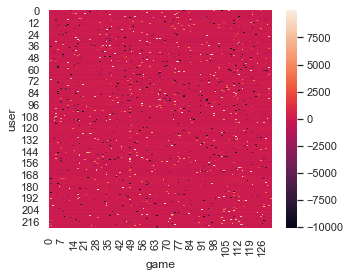

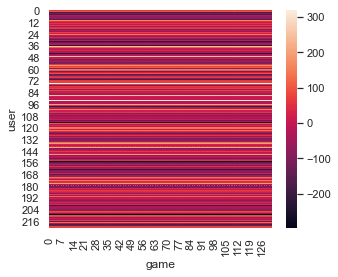

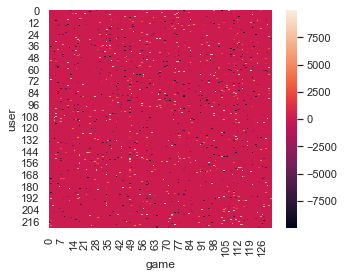

Robust PCA RMSE: 317.9333517427724
Imputing row 1/223 with 77 missing, elapsed time: 0.040
Imputing row 101/223 with 102 missing, elapsed time: 0.144
Imputing row 201/223 with 98 missing, elapsed time: 0.257


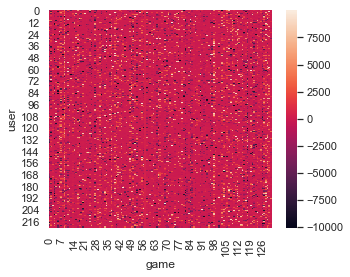

K Nearest Neighbors RMSE: 1829.2314265417738
-------------------------------------------
Percent of Data Corrupted: 20.0%
Matrix Completion RMSE: 1316.4027507386984


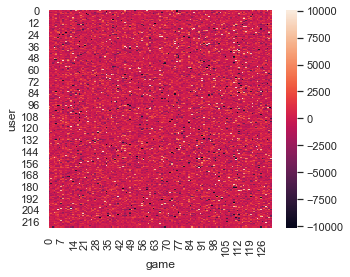

iteration: 1, error: 148.34657077793577
iteration: 100, error: 0.8997832528596059
iteration: 200, error: 0.8257029158787318
iteration: 300, error: 1.6854790494773313
iteration: 400, error: 1.9145384790645787
iteration: 500, error: 3.561131256203665
iteration: 600, error: 3.1810580753650024
iteration: 700, error: 4.586772795071039
iteration: 800, error: 4.729122751771328
iteration: 900, error: 4.397585798388217
iteration: 1000, error: 6.482400051721918
iteration: 1100, error: 4.5043746125534865
iteration: 1200, error: 3.623083232416646
iteration: 1300, error: 3.9882198700874034
iteration: 1400, error: 5.708536638478126
iteration: 1500, error: 0.48305425878944713
iteration: 1600, error: 0.8720321387212949
iteration: 1700, error: 0.5230049890997819
iteration: 1800, error: 0.8574887456731295
iteration: 1900, error: 0.41806953461014174
iteration: 2000, error: 0.8026616851096386
iteration: 2100, error: 0.409031004620453
iteration: 2200, error: 0.6582662742467433
iteration: 2300, error: 0.721

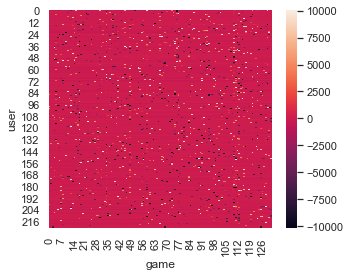

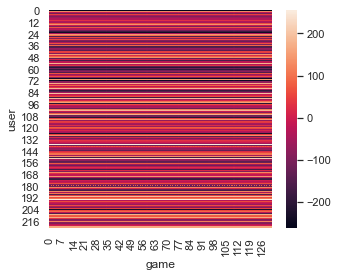

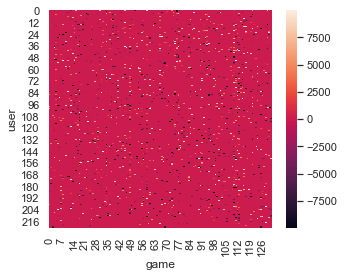

Robust PCA RMSE: 317.94969019824214
Imputing row 1/223 with 77 missing, elapsed time: 0.040
Imputing row 101/223 with 102 missing, elapsed time: 0.146
Imputing row 201/223 with 98 missing, elapsed time: 0.263


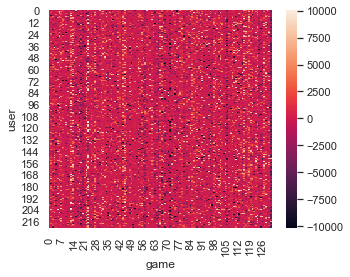

K Nearest Neighbors RMSE: 2269.5598293187677
-------------------------------------------
Percent of Data Corrupted: 24.999999999999996%
Matrix Completion RMSE: 1427.3914845306683


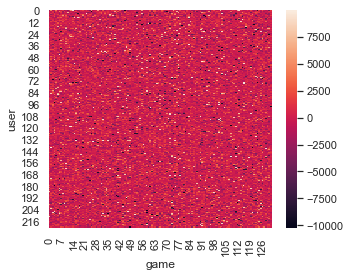

iteration: 1, error: 205.5433145770281
iteration: 100, error: 0.2608491361941369
iteration: 200, error: 0.5832962501823503
iteration: 300, error: 2.9325156467489144
iteration: 400, error: 5.127296928699043
iteration: 500, error: 4.433607858844458
iteration: 600, error: 6.116410364711128
iteration: 700, error: 8.094097586078108
iteration: 800, error: 7.163091280202092
iteration: 900, error: 7.805603207983284
iteration: 1000, error: 6.205482327484116
iteration: 1100, error: 6.018399150994704
iteration: 1200, error: 3.188069305871161
iteration: 1300, error: 2.7604283232679823
iteration: 1400, error: 1.0341635693056075
iteration: 1500, error: 1.4530168474886647
iteration: 1600, error: 1.2534610436060722
iteration: 1700, error: 0.9399259973592712
iteration: 1800, error: 0.27435211270774224
iteration: 1900, error: 0.40144185916124697
iteration: 2000, error: 0.48308197245400925
iteration: 2100, error: 1.6875841976042334
iteration: 2200, error: 0.1096843687032029
iteration: 2300, error: 0.0555

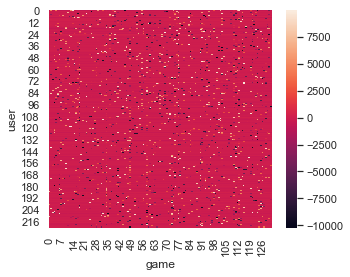

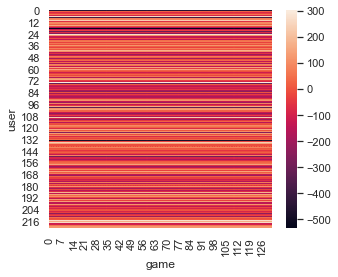

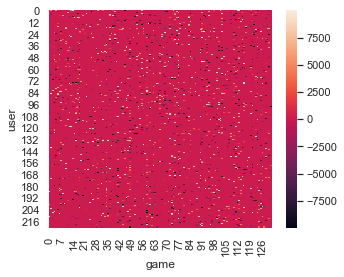

Robust PCA RMSE: 317.84874580814966
Imputing row 1/223 with 77 missing, elapsed time: 0.037
Imputing row 101/223 with 102 missing, elapsed time: 0.143
Imputing row 201/223 with 98 missing, elapsed time: 0.254


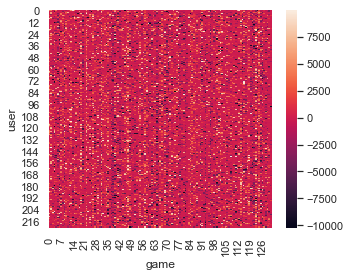

K Nearest Neighbors RMSE: 2069.1355443807374
-------------------------------------------
Percent of Data Corrupted: 30.0%
Matrix Completion RMSE: 1612.6738025970226


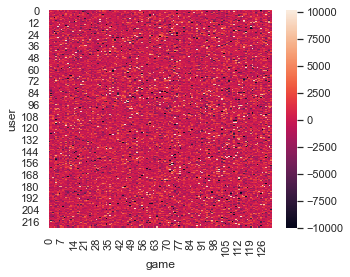

iteration: 1, error: 226.88404847026163
iteration: 100, error: 0.6082135108495128
iteration: 200, error: 1.7716242287008654
iteration: 300, error: 2.1596901967476296
iteration: 400, error: 4.647377378654717
iteration: 500, error: 5.914823197512841
iteration: 600, error: 6.686981933595635
iteration: 700, error: 6.891773281831572
iteration: 800, error: 6.633361533396021
iteration: 900, error: 8.159289403768927
iteration: 1000, error: 4.651900027533431
iteration: 1100, error: 1.6237184726829539
iteration: 1200, error: 5.782933473008228
iteration: 1300, error: 3.3946701003767394
iteration: 1400, error: 0.6729911497813477
iteration: 1500, error: 1.3164619021349033
iteration: 1600, error: 0.7734806535880123
iteration: 1700, error: 0.6215188419075993
iteration: 1800, error: 0.7957655846287602
iteration: 1900, error: 0.6700180640526363
iteration: 2000, error: 0.3191485689836393
iteration: 2100, error: 0.8835985082961347
iteration: 2200, error: 1.3248780774458164
iteration: 2300, error: 0.11081

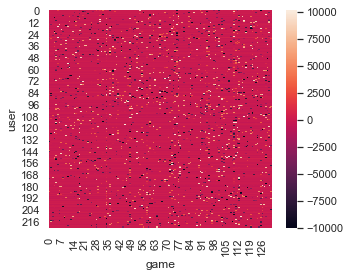

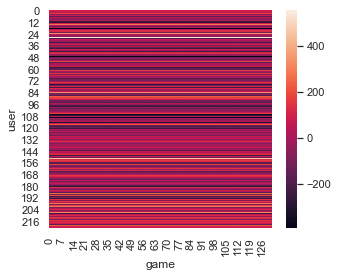

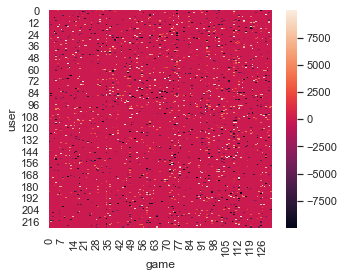

Robust PCA RMSE: 317.9112772716602
Imputing row 1/223 with 77 missing, elapsed time: 0.037
Imputing row 101/223 with 102 missing, elapsed time: 0.140
Imputing row 201/223 with 98 missing, elapsed time: 0.251


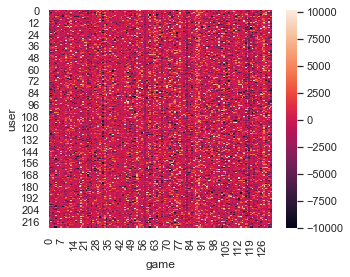

K Nearest Neighbors RMSE: 2369.024539316537


In [99]:
errors_mc = []
errors_rpca = []
errors_knn = []
for i in range(len(A_list)):
    t = thresholds[i]
    A = A_list[i]
    
    print('-------------------------------------------')
    
    print("Percent of Data Corrupted: {}%".format(t*100))
    
    # Center Matrix
    A_mean = np.tile(np.mean(A, axis=1), (A.shape[1], 1)).T
    A_centered = A - A_mean
    
    # Perform Matrix Completion using Nuclear Norm
    m = 1/np.sqrt(max(A_centered.shape))
    R_hat = mc.nuclear_norm_solve(A_centered, B, mu=m)
    
    # Display RMSE of Matrix Completion
    rmse_mc = calc_rmse(test_coords.keys(), R_hat + A_mean)
    errors_mc.append(rmse_mc)
    print("Matrix Completion RMSE: {}".format(rmse_mc))
    
    # Display Matrix Completion Heatmap
    fig, ax = plt.subplots(figsize=(5,4))
    ax = sns.heatmap(R_hat)
    plt.xlabel("game")
    plt.ylabel("user")
    plt.show()
    
    # Perform RPCA
    rpca = R_pca(A_centered)
    L, S = rpca.fit(max_iter=10000, iter_print=100)
    
    # Display RPCA Heatmaps
    fig, ax = plt.subplots(figsize=(5,4))
    ax = sns.heatmap(A_centered)
    plt.xlabel("game")
    plt.ylabel("user")
    plt.show()
    fig, ax = plt.subplots(figsize=(5,4))
    ax = sns.heatmap(L)
    plt.xlabel("game")
    plt.ylabel("user")
    plt.show()
    fig, ax = plt.subplots(figsize=(5,4))
    ax = sns.heatmap(S)
    plt.xlabel("game")
    plt.ylabel("user")
    plt.show()
    
    # Display RMSE of RPCA
    rmse_rpca = calc_rmse(test_coords.keys(), L + A_mean)
    errors_rpca.append(rmse_rpca)
    print("Robust PCA RMSE: {}".format(rmse_rpca))
    
    # Perform K Nearest Neighbors
    A_centered[B==0]=np.nan
    R_knn = KNN(k=3).fit_transform(A_centered)
    
    # Display K Nearest Neighbors Heatmap
    fig, ax = plt.subplots(figsize=(5,4))
    ax = sns.heatmap(R_knn)
    plt.xlabel("game")
    plt.ylabel("user")
    plt.show()
    
    # Display RMSE of K Nearest Neighbors
    rmse_knn = calc_rmse(test_coords.keys(), R_knn + A_mean)
    errors_knn.append(rmse_knn)
    print("K Nearest Neighbors RMSE: {}".format(rmse_knn))

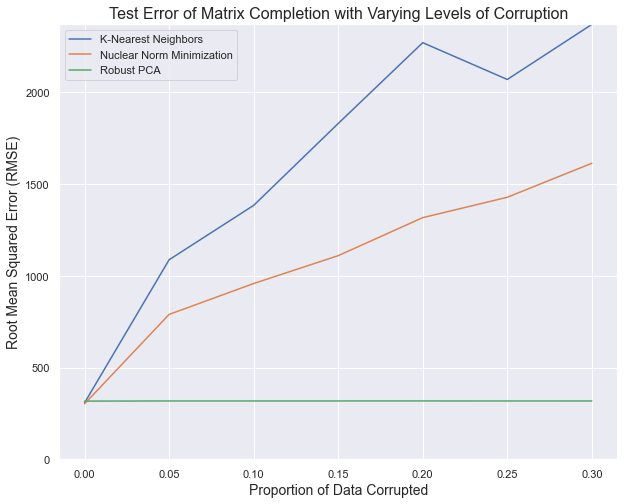

In [97]:
fig, ax = plt.subplots(figsize=(10, 8))
line3, = ax.plot(thresholds, errors_knn, label='K-Nearest Neighbors')
line1, = ax.plot(thresholds, errors_mc, label='Nuclear Norm Minimization')
line2, = ax.plot(thresholds, errors_rpca, label='Robust PCA')
ax.legend()
plt.title("Test Error of Matrix Completion with Varying Levels of Corruption", size=16)
plt.xlabel("Proportion of Data Corrupted", size=14)
plt.ylabel("Root Mean Squared Error (RMSE)", size=14)
plt.ylim(0, np.max(errors_knn))
plt.savefig('rmse.png', transparent=True)